In [1]:
%matplotlib inline
import sys
import os
import psycopg2
import psycopg2.extras
import pandas
import numpy
import matplotlib
from matplotlib import pyplot

In [2]:
# Make database connection
with open( os.path.join( os.getenv("HOME"), "secrets/decatdb_decat_decat_ro" ) ) as ifp:
    (username, password) = ifp.readline().split()
db = psycopg2.connect( dbname="decat", host="decatdb.lbl.gov", port=5432, user=username, password=password,
                       cursor_factory=psycopg2.extras.RealDictCursor )

In [3]:
# A function for calculating a limiting magnitude
DEFAULT_SIGLIM = 7
def add_lmtmag( data, siglim=7, gain=4, field='calclim' ):
    fivesigflux = 1./2. * ( siglim**2/gain + numpy.sqrt( siglim**4/gain**2 + 4.* siglim**2 * data['skysig']**2 * 3.1416 * (0.6731*data['seeing']/0.263)**2 ) )
    data['calclim'] = -2.5 * numpy.log10(fivesigflux) + data['subzp']


In [4]:
# Search defintions for some fields
# Assuming that "exposures" will have an alias e
radec = { 'COSMOS-1': "e.ra>149.9 AND e.ra<150.1 AND e.dec>3.0 AND e.dec<3.2",
          'COSMOS-2': "e.ra>150.68 AND e.ra<150.88 AND e.dec>1.65 AND e.dec<1.85",
          'COSMOS-3': "e.ra>149.12 AND e.ra<149.33 AND e.dec>1.65 AND e.dec<1.85",
          'ELIAS-E1': "e.ra>7.77 AND e.ra<7.97 AND e.dec>-43.1 AND e.dec<-42.9",
          'ELIAS-E2': "e.ra>9.4 AND e.ra<9.6 AND e.dec>-44.1 AND e.dec<-43.9",
          'DECaPS-East': "e.ra>270.8 AND e.ra<271 AND e.dec>-30.5 AND e.dec<-28.5",
          'DECaPS-West': "e.ra>115.3 AND e.ra<117.3 AND e.dec>-27.3 AND e.dec<-25.3" }
exgalfields = [ 'COSMOS-1', 'COSMOS-2', 'COSMOS-3', 'ELIAS-E1', 'ELIAS-E2' ]
galfields = [ 'DECaPS-East', 'DECaPS-West' ]
allfields = [ 'COSMOS-1', 'COSMOS-2', 'COSMOS-3', 'ELIAS-E1', 'ELIAS-E2', 'DECaPS-East', 'DECaPS-West' ]
fields = allfields
rfilt = "e.filter='r'"
gfilt = "e.filter='g'"
ifilt = "e.filter='i'"
zfilt = "e.filter='z'"
filters = [ 'g', 'r', 'i', 'z' ]
filtcuts = [ gfilt, rfilt, ifilt, zfilt ]
rgifzilts = "e.filter IN ('r','g','i','z')"
props = "e.proposalid IN ('2021A-0113','2021B-0149')"
# stdexp = { 'g': "(e.header->>'EXPTIME')::float=60",
#            'r': "(e.header->>'EXPTIME')::float=86",
#            'i': "(e.header->>'EXPTIME')::float=130" }

In [5]:
# List the first exposure for each field/filter
db.rollback()
cursor = db.cursor()
for field in fields:
    for filter, filtcut in zip( filters, filtcuts ):
        q = ( f"SELECT filename,(header->>'EXPTIME')::float AS exptime "
              f"FROM exposures e "
              f"WHERE {props} AND {radec[field]} AND {filtcut} "
              f"   AND (e.header->>'EXPTIME')::float>20 ORDER BY mjd LIMIT 1" )
        cursor.execute(q)
        row = cursor.fetchone()
        sys.stderr.write( f'{field}  {filter}  {row["filename"] if row is not None else "---"}  {row["exptime"] if row is not None else "---"}\n' )

COSMOS-1  g  c4d_210319_003604_ori.fits.fz  60.0
COSMOS-1  r  c4d_210319_003732_ori.fits.fz  86.0
COSMOS-1  i  c4d_210319_003928_ori.fits.fz  130.0
COSMOS-1  z  ---  ---
COSMOS-2  g  c4d_210319_003000_ori.fits.fz  60.0
COSMOS-2  r  c4d_210319_003128_ori.fits.fz  86.0
COSMOS-2  i  c4d_210319_003322_ori.fits.fz  130.0
COSMOS-2  z  ---  ---
COSMOS-3  g  c4d_210319_002356_ori.fits.fz  60.0
COSMOS-3  r  c4d_210319_002525_ori.fits.fz  86.0
COSMOS-3  i  c4d_210319_002721_ori.fits.fz  130.0
COSMOS-3  z  ---  ---
ELIAS-E1  g  c4d_210522_083408_ori.fits.fz  60.0
ELIAS-E1  r  c4d_210522_083537_ori.fits.fz  86.0
ELIAS-E1  i  c4d_210522_083731_ori.fits.fz  130.0
ELIAS-E1  z  ---  ---
ELIAS-E2  g  c4d_210522_084011_ori.fits.fz  60.0
ELIAS-E2  r  c4d_210522_084141_ori.fits.fz  86.0
ELIAS-E2  i  c4d_210522_084334_ori.fits.fz  130.0
ELIAS-E2  z  c4d_210527_104154_ori.fits.fz  60.0
DECaPS-East  g  c4d_210322_091333_ori.fits.fz  96.0
DECaPS-East  r  c4d_210322_091538_ori.fits.fz  50.0
DECaPS-East  i  c4d

In [6]:
db.rollback()
cursor=db.cursor()
fieldinfo = pandas.DataFrame()
for fieldname in fields:
    q = ( f"SELECT COUNT(filename),filter,header->'EXPTIME' AS exptime FROM exposures e "
          f"WHERE ( {radec[fieldname]} ) AND ( {props} ) GROUP BY filter,exptime" )
    # sys.stderr.write( f"Executing query {q}\n" )
    cursor.execute(q)
    df = pandas.DataFrame( cursor.fetchall() )
    df['field'] = fieldname
    fieldinfo = pandas.concat( [ fieldinfo, df ] )

fieldinfo.sort_values( ['field','filter','exptime'], inplace=True )
fieldinfo.set_index( ['field','filter'], inplace=True )

In [7]:
pandas.set_option('display.max_rows', 500)
fieldinfo

count  exptime
field       filter                
COSMOS-1    g          29     10.0
            g         117     60.0
            g          18     80.0
            i          12     30.0
            i          18     90.0
            i         113    130.0
            r           8     30.0
            r          18     70.0
            r         113     86.0
COSMOS-2    g          26     10.0
            g         114     60.0
            g          18     80.0
            i           9     30.0
            i          18     90.0
            i         110    130.0
            r           6     30.0
            r          18     70.0
            r         110     86.0
COSMOS-3    g          25     10.0
            g         118     60.0
            g          18     80.0
            i           9     30.0
            i          18     90.0
            i         113    130.0
            r           6     30.0
            r          18     70.0
            r         115     86.0
DECaPS-East g         239     96.0
            i         257     30.0
            r          10     25.0
            r         239     50.0
            z         271     30.0
DECaPS-West g         259     96.0
            i         251     30.0
            r         256     50.0
            z         249     30.0
ELIAS-E1    g           8     10.0
            g         187     60.0
            i           1     10.0
            i         186    130.0
            r         186     86.0
ELIAS-E2    g           4     10.0
            g         176     60.0
            i         173    130.0
            r         175     86.0
            z           2     60.0

In [8]:
# Pull out all subtractions, and make a "normzp" field that is the zeropoint scaled to the same exposure time (tstd)
# and calclim that is the 5σ expected detection limit
db.rollback
cursor = db.cursor()
subinfo = []
for fieldname in fields:
    q = ( f"SELECT e.filename,i.ccdnum,s.seeing,s.skysig,s.magzp AS subzp, i.magzp AS imgzp,s.lmt_mg,e.filter,(e.header->>'EXPTIME')::float AS exptime,e.mjd "
          f"FROM subtractions s INNER JOIN images i ON s.image_id=i.id INNER JOIN exposures e ON s.exposure_id=e.id "
          f"WHERE {radec[fieldname]} AND {props}" )
    cursor.execute( q )
    df = pandas.DataFrame( cursor.fetchall() )
    df['field'] = fieldname
    subinfo.append( df )
subinfo = pandas.concat( subinfo )
subinfo.sort_values( [ 'field', 'filter', 'exptime' ], inplace=True )
subinfo.set_index( ['field', 'filter'], inplace=True )
tstd = 60
subinfo['normzp'] = subinfo['subzp'] + 2.5*numpy.log10( tstd / subinfo['exptime'] )

add_lmtmag( subinfo )
subinfo

filename  ccdnum    seeing     skysig  \
field    filter                                                               
COSMOS-1 g       c4d_210610_234328_ori.fits.fz      17  1.319185   2.074463   
         g       c4d_210610_234328_ori.fits.fz      38  1.390467   1.827872   
         g       c4d_210610_234328_ori.fits.fz      32  1.431169   1.976328   
         g       c4d_210610_234328_ori.fits.fz       2  1.489868   1.783640   
         g       c4d_210610_234328_ori.fits.fz      50  1.373283   1.906170   
...                                        ...     ...       ...        ...   
ELIAS-E2 z       c4d_210527_104323_ori.fits.fz      46  0.964826  32.390137   
         z       c4d_210527_104323_ori.fits.fz      55  1.005784  40.787109   
         z       c4d_210527_104323_ori.fits.fz      52  0.957999  31.825928   
         z       c4d_210527_104323_ori.fits.fz      27  0.974625  36.779297   
         z       c4d_210527_104323_ori.fits.fz      30  0.960697  41.201660   

                     subzp      imgzp     lmt_mg  exptime           mjd  \
field    filter                                                           
COSMOS-1 g       27.165983  27.165983  22.621668     10.0  59375.988529   
         g       26.827559  26.827559  22.358171     10.0  59375.988529   
         g       27.027383  27.027383  22.449457     10.0  59375.988529   
         g       26.871972  26.871972  22.357484     10.0  59375.988529   
         g       27.047259  27.047259  22.548019     10.0  59375.988529   
...                    ...        ...        ...      ...           ...   
ELIAS-E2 z       28.812091  28.812091  21.680918     60.0  59361.446801   
         z       28.894880  28.894880  21.469457     60.0  59361.446801   
         z       28.841946  28.841946  21.737439     60.0  59361.446801   
         z       28.862627  28.862627  21.583134     60.0  59361.446801   
         z       28.788744  28.788744  21.402002     60.0  59361.446801   

                    normzp    calclim  
field    filter                        
COSMOS-1 g       29.111361  22.241997  
         g       28.772937  21.977978  
         g       28.972761  22.070029  
         g       28.817350  21.977601  
         g       28.992637  22.168029  
...                    ...        ...  
ELIAS-E2 z       28.812091  21.313743  
         z       28.894880  21.102712  
         z       28.841946  21.370219  
         z       28.862627  21.216189  
         z       28.788744  21.035207  

[259787 rows x 11 columns]

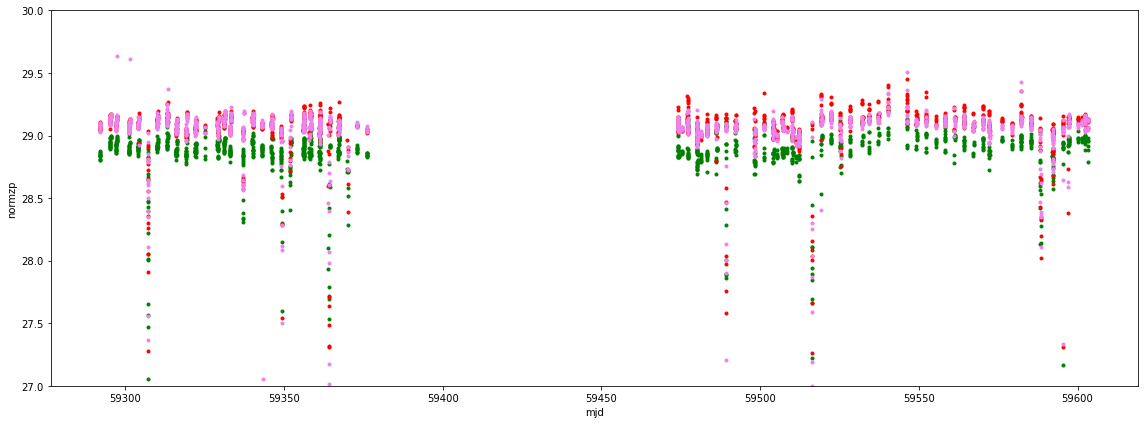

In [9]:
ccdnum = 10
fig = pyplot.figure( figsize=(16,6), tight_layout=True )
ax = fig.add_subplot( 1, 1, 1 )
filters = ['g', 'r', 'i']
colors = ['green', 'red', 'violet' ]
plotfield = 'normzp'
for filter, color in zip ( filters, colors ):
    subsubinfo = subinfo[ subinfo['ccdnum']==ccdnum ].xs( filter, level=1 )
    ax.scatter( subsubinfo['mjd'], subsubinfo[plotfield], marker='.', color=color )
ax.set_xlabel( 'mjd' )
ax.set_ylabel( plotfield )
# ax.set_xlim(59580, 59610)
ax.set_ylim( 27,30 )
fig.show()
    

In [10]:
Cfilt = {}
Efilt = {}
for filt in [ 'g', 'r', 'i' ]:
    Cfilt[filt] = subinfo.loc[ [ ('COSMOS-1', filt), ('COSMOS-2', filt), ('COSMOS-3', filt) ] ]
    Efilt[filt] = subinfo.loc[ [ ('ELIAS-E1', filt), ('ELIAS-E2', filt) ] ]
DWfilt = {}
DEfilt = {}
for filt in [ 'g', 'r', 'i', 'z' ]:
    DWfilt[filt] = subinfo.loc[ ('DECaPS-West', filt) ]
    DEfilt[filt] = subinfo.loc[ ('DECaPS-East', filt) ]

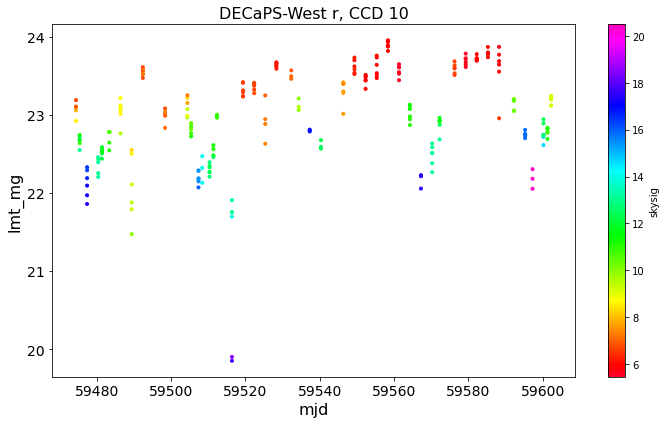

In [11]:
# Plot info vs. time

fig = pyplot.figure( figsize=(10,6), tight_layout=True )
ax = fig.add_subplot( 1, 1, 1 )
fullset = DWfilt['r']
title = "DECaPS-West r, CCD 10"
dataset = fullset[ fullset['ccdnum'] == 10 ]
# dataset = subinfo[ subinfo['ccdnum'] == 10 ].xs( 'r', level=1 )
x = 'mjd'
y = 'lmt_mg'
c = 'skysig'
ax.tick_params( 'both', labelsize=14 )
sc = ax.scatter( dataset[x], dataset[y], c=dataset[c], cmap='gist_rainbow', marker='.' )
ax.set_xlabel( x, fontsize=16 )
ax.set_ylabel( y, fontsize=16 )
ax.set_title( title, fontsize=16 )
#ax.set_xlim( 59550, 59610 )
cb = fig.colorbar(sc)
cb.set_label( c )
fig.show()
fig.savefig( 'it.svg' )

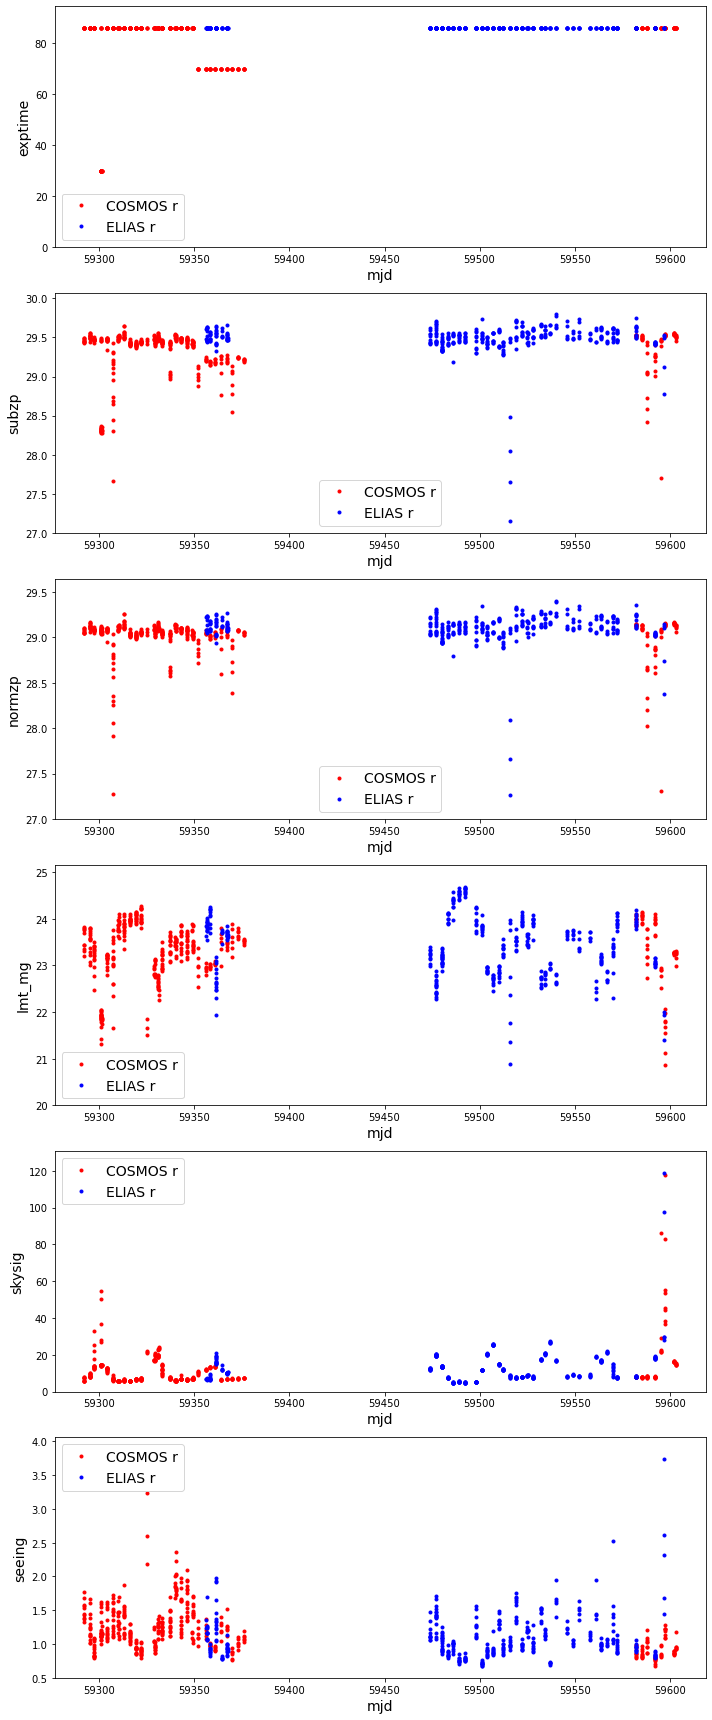

In [12]:
# Compare two fields
x = 'mjd'
yvals = [ 'exptime', 'subzp', 'normzp', 'lmt_mg', 'skysig', 'seeing' ]
ymins = [ 0, 27, 27, 20, 0, 0.5 ]
subsets = [ Cfilt['r'], Efilt['r'] ]
labels = [ "COSMOS r", "ELIAS r" ]
# subsets = [ DWfilt['r'], DEfilt['r'] ]
# labels = [ "DECaPS-West r", "DECaPS-East r" ]
colors = [ 'red', 'blue' ]
fig = pyplot.figure( figsize=(10,4*len(yvals)), tight_layout=True )
xlims = None
ccdnum = 10
for i, yval in enumerate(yvals):
    ax = fig.add_subplot( len(yvals), 1, i+1 )
    if xlims is not None:
        ax.set_xrange( xlims[0], xlims[1] )
    ax.set_xlabel( 'mjd', fontsize=14 )
    if ccdnum is not None:
        ax.set_ylabel( f'{yval} (CCD {ccdnum})' )
    ax.set_ylabel( yval, fontsize=14 )
    maxy = -1e32
    for dataset, color, label in zip( subsets, colors, labels ):
        if ccdnum is not None:
            dataset = dataset[ dataset['ccdnum']==ccdnum ]
        ax.plot( dataset['mjd'], dataset[yval], linestyle='None', marker='.', color=color, label=label )
        if dataset[yval].max() > maxy:
            maxy = dataset[yval].max()
    ax.set_ylim( ymins[i], maxy+0.1*(maxy-ymins[i]) )
    ax.legend( fontsize=14 )
fig.show()
fig.savefig('it.svg')

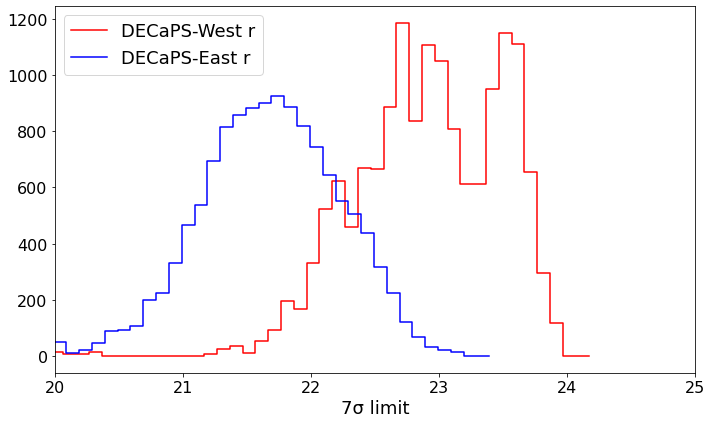

In [13]:
# Histograms of limiting magnitude
fig = pyplot.figure( figsize=(10,6), tight_layout=True )
ax = fig.add_subplot( 1, 1, 1 )
ax.set_xlabel( f"{DEFAULT_SIGLIM}σ limit", fontsize=18 )
ax.tick_params( 'both', labelsize=16 )
field = "lmt_mg"
#for dataset, color, label in zip( [ Cfilt['r'], Efilt['r'] ], [ 'red', 'blue' ], [ 'COSMOS r', 'ELIAS r' ] ):
for dataset, color, label in zip( [ DWfilt['r'], DEfilt['r'] ], [ 'red', 'blue' ], [ 'DECaPS-West r', 'DECaPS-East r' ] ):
    setmin = min( dataset['lmt_mg'] )
    setmax = max( dataset['lmt_mg'] )
    binwidth = 0.1
    bins = numpy.arange( setmin, setmax+2*binwidth, binwidth )
    hist, edges = numpy.histogram( dataset['lmt_mg'], bins=bins )
    hist = numpy.append( hist, [0] )
    ax.step( edges, hist, color=color, label=label )
ax.legend( fontsize=18 )
ax.set_xlim( 20, 25 )
fig.show()
fig.savefig('it.svg')

13906 objects for DECaPS-West
310873 objects for DECaPS-East


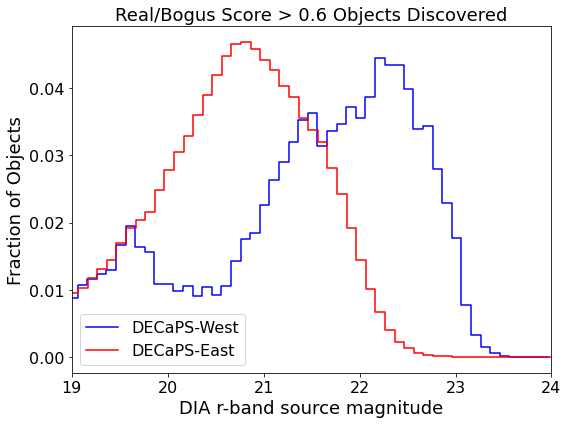

In [14]:
# Histograms of numbers of objects with r/b>0.6
# radeccuts = [ f"({radec['ELIAS-E1']}) OR ({radec['ELIAS-E2']})",
#               f"({radec['COSMOS-1']}) OR ({radec['COSMOS-2']}) OR ({radec['COSMOS-3']})" ]
# labels = [ "ELIAS", "COSMOS" ]
radeccuts = [ radec['DECaPS-West'], radec['DECaPS-East'] ]
labels = [ "DECaPS-West", "DECaPS-East" ]
colors = [ 'blue', 'red' ]
ccdnum = None
rbcut = 0.6
rbtype = 1
band = 'r'
minexptime = 0
maxexptime = 9999
db.rollback()
cursor = db.cursor()
fig = pyplot.figure( figsize=(8,6), tight_layout=True )
ax = fig.add_subplot( 1, 1, 1 )
ax.set_xlabel( f'DIA {band}-band source magnitude', fontsize=18 )
ax.set_ylabel( f'Fraction of Objects', fontsize=18 )
ax.tick_params( 'both', labelsize=16 )
# if ccdnum is None:
#     ax.set_title( f'All ccds, {minexptime}<exptime<{maxexptime}', fontsize=18 )
# else:
#     ax.set_label( f'CCD {ccdnum}, {minexptime}<exptime<{maxexptime}', fontsize=18 )
ax.set_title( f'Real/Bogus Score > {rbcut} Objects Discovered', fontsize=18 )
for radeccut, label, color in zip( radeccuts, labels, colors ):
    q = ( "SELECT o.mag,e.header->'EXPTIME' AS exptime FROM objects o "
          "INNER JOIN subtractions s ON o.subtraction_id=s.id "
          "INNER JOIN exposures e ON s.exposure_id=e.id "
          "INNER JOIN objectrbs r ON r.object_id=o.id "
          "WHERE r.rbtype_id=%(rbtype)s AND r.rb>%(rbcut)s "
         f"  AND {props} "
          "  AND e.filter=%(filter)s "
         f"  AND ({radeccut}) "
        )
    if ccdnum is not None:
        q += "  AND ccdnum=%(ccdnum)s "
    params = { "ccdnum": ccdnum,
               "rbtype": rbtype,
               "rbcut": rbcut,
               "filter": band }
    cursor.execute( q, params )
    data = pandas.DataFrame( cursor.fetchall() )
    data = data[ ( data['exptime'] > minexptime ) & ( data['exptime'] < maxexptime ) ]
    print( f'{len(data)} objects for {label}' )
    setmin = min( data['mag'] )
    setmax = max( data['mag'] )
    bins = numpy.arange( setmin, setmax+2*binwidth, binwidth )
    hist, edges = numpy.histogram( data['mag'], bins=bins )
    hist = numpy.append( hist, [0] )
    ax.step( edges, hist/hist.sum(), color=color, label=label )
    # ax.step( edges, hist, color=color, label=label )
ax.legend( fontsize=16 )
ax.set_xlim( 19,24 )
fig.show()
fig.savefig("it.svg")

Query:
b"SELECT e.filename,e.mjd,s.lmt_mg,s.seeing,s.skysig,s.magzp AS subzp,AVG(o.mag) AS avgmag FROM exposures e INNER JOIN subtractions s ON s.exposure_id=e.id INNER JOIN objects o ON o.subtraction_id=s.id INNER JOIN objectrbs r ON r.object_id=o.id WHERE r.rbtype_id=1 AND r.rb>=0.6   AND e.proposalid IN ('2021A-0113','2021B-0149')   AND ccdnum=10   AND ((e.ra>7.77 AND e.ra<7.97 AND e.dec>-43.1 AND e.dec<-42.9) OR (e.ra>9.4 AND e.ra<9.6 AND e.dec>-44.1 AND e.dec<-43.9)) GROUP BY e.filename,e.mjd,s.lmt_mg,s.seeing,s.skysig,s.magzp"
Query:
b"SELECT e.filename,e.mjd,s.lmt_mg,s.seeing,s.skysig,s.magzp AS subzp,AVG(o.mag) AS avgmag FROM exposures e INNER JOIN subtractions s ON s.exposure_id=e.id INNER JOIN objects o ON o.subtraction_id=s.id INNER JOIN objectrbs r ON r.object_id=o.id WHERE r.rbtype_id=1 AND r.rb>=0.6   AND e.proposalid IN ('2021A-0113','2021B-0149')   AND ccdnum=10   AND ((e.ra>149.9 AND e.ra<150.1 AND e.dec>3.0 AND e.dec<3.2) OR (e.ra>150.68 AND e.ra<150.88 AND e.dec>1.65

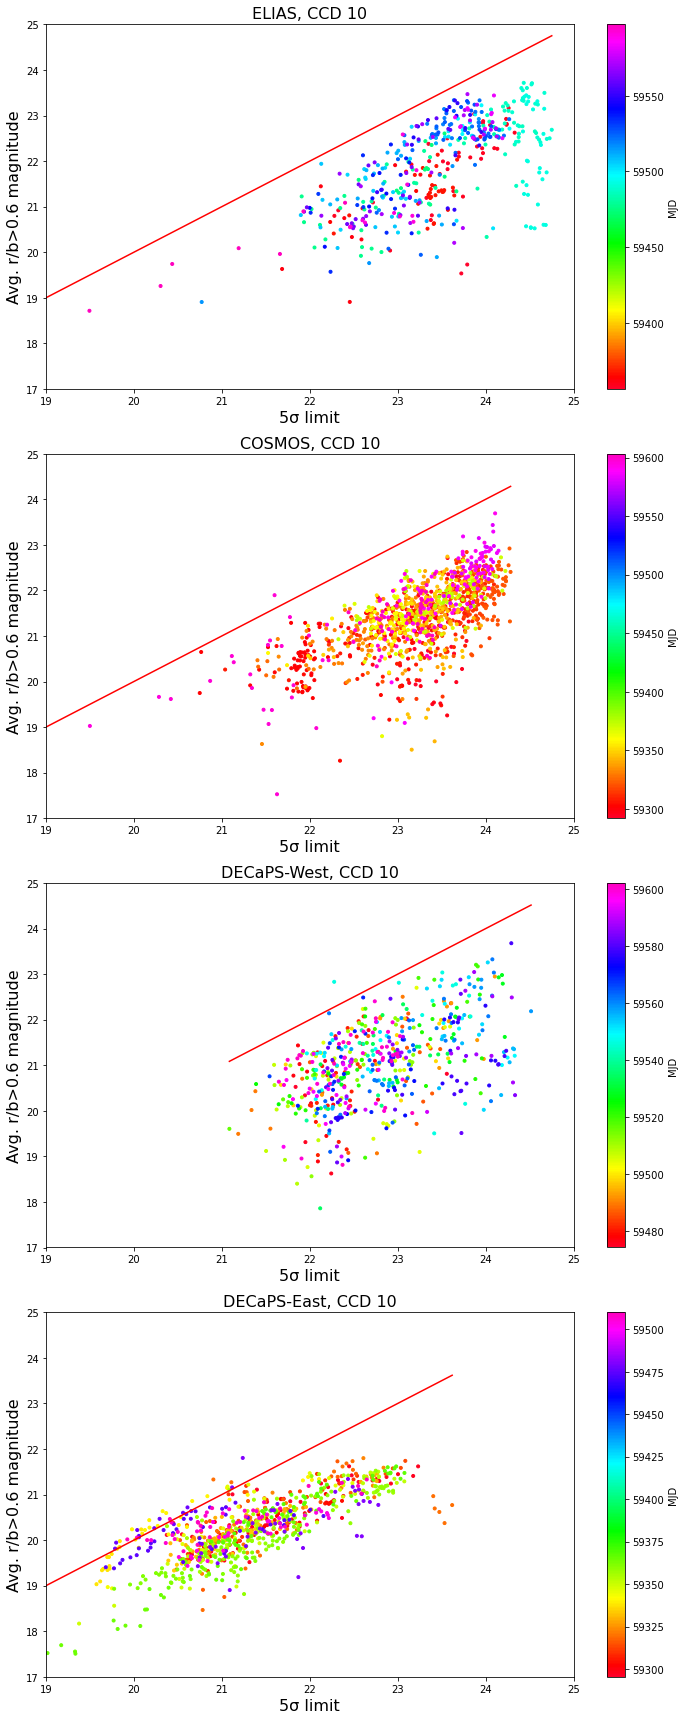

In [15]:
# Limiting magnitude vs. average magnitude of rb>0.6 sources

# radeccut = 
# plottitle = "COSMOS, CCD 10"
radeccuts = [ f"({radec['ELIAS-E1']}) OR ({radec['ELIAS-E2']})",
              f"({radec['COSMOS-1']}) OR ({radec['COSMOS-2']}) OR ({radec['COSMOS-3']})",
              radec['DECaPS-West'],
              radec['DECaPS-East'] ]
plottitles = [ "ELIAS, CCD 10", "COSMOS, CCD 10", "DECaPS-West, CCD 10", "DECaPS-East, CCD 10" ]
ccdnum = 10
rbcut = 0.6
rbtype = 1
binwidth = 0.1
db.rollback()
cursor = db.cursor()
fig = pyplot.figure( figsize=(10,6*len(plottitles)), tight_layout=True )
i = -1
for radeccut, plottitle in zip( radeccuts, plottitles ):
    i += 1
    q = ( "SELECT e.filename,e.mjd,s.lmt_mg,s.seeing,s.skysig,s.magzp AS subzp,AVG(o.mag) AS avgmag FROM exposures e "
          "INNER JOIN subtractions s ON s.exposure_id=e.id "
          "INNER JOIN objects o ON o.subtraction_id=s.id "
          "INNER JOIN objectrbs r ON r.object_id=o.id "
          "WHERE r.rbtype_id=%(rbtype)s AND r.rb>=%(rbcut)s "
          f"  AND {props} "
        )
    if ccdnum is not None:
        q += "  AND ccdnum=%(ccdnum)s "
    if radeccut is not None:
        q += f"  AND ({radeccut}) "
    params = { "ccdnum": ccdnum,
               "rbtype": rbtype,
               "rbcut": rbcut }
    q += "GROUP BY e.filename,e.mjd,s.lmt_mg,s.seeing,s.skysig,s.magzp"
    sys.stderr.write( f"Query:\n{cursor.mogrify(q, params)}\n" )
    cursor.execute( q, params )
    data = pandas.DataFrame( cursor.fetchall() )

    # Gotta do that limiting magnitude calculation again
    add_lmtmag( data )
    
    ax = fig.add_subplot( len(plottitles), 1, i+1 )
    ax.set_title( plottitle, fontsize=16 )
    ax.set_ylabel( "Avg. r/b>0.6 magnitude", fontsize=16 )
    ax.set_xlabel( f"5σ limit", fontsize=16 )
    ax.set_xlim( 19, 25 )
    ax.set_ylim( 17, 25 )
    sc = ax.scatter( data['lmt_mg'], data['avgmag'], c=data['mjd'], marker='.', cmap='gist_rainbow' )
    mm = [ data['lmt_mg'].min(), data['lmt_mg'].max() ]
    ax.plot( mm, mm, color='red' )
    cb = fig.colorbar( sc )
    cb.set_label( 'MJD' )
fig.show()
fig.savefig("it.png")

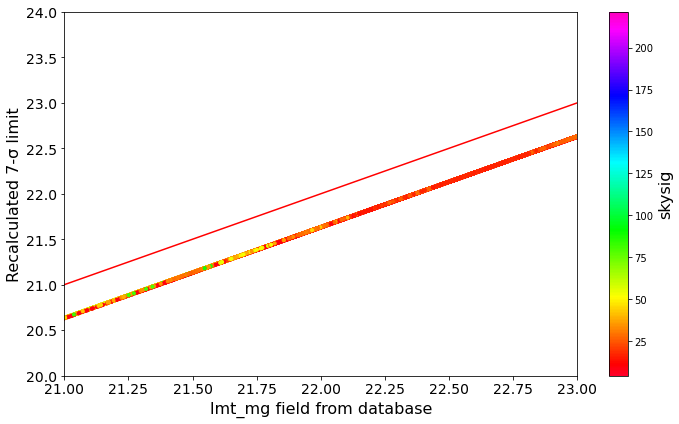

In [16]:
# Plot limiting magnitude vs. what we'd expect in a 0.6731*FWHM radius aperture
tmpinfo = subinfo.copy()
tmpinfo = tmpinfo.xs( 'r', level=1  )
fig = pyplot.figure( figsize=(10,6), tight_layout=True )
ax = fig.add_subplot( 1, 1, 1 )
ax.tick_params( 'both', labelsize=14 )
ax.set_xlabel( 'lmt_mg field from database', fontsize=16 )
ax.set_ylabel( f'Recalculated {DEFAULT_SIGLIM}-σ limit', fontsize=16 )
sc = ax.scatter( tmpinfo['lmt_mg'], tmpinfo['calclim'], c=tmpinfo['skysig'], cmap='gist_rainbow', marker='.' )
cb = fig.colorbar( sc )
cb.set_label( 'skysig', fontsize=16 )
minmax = [ min(tmpinfo['lmt_mg']), max(tmpinfo['lmt_mg']) ]
ax.plot( minmax, minmax, color='red' )
ax.set_xlim( 21, 23 )
ax.set_ylim( 20, 24 )
fig.show()

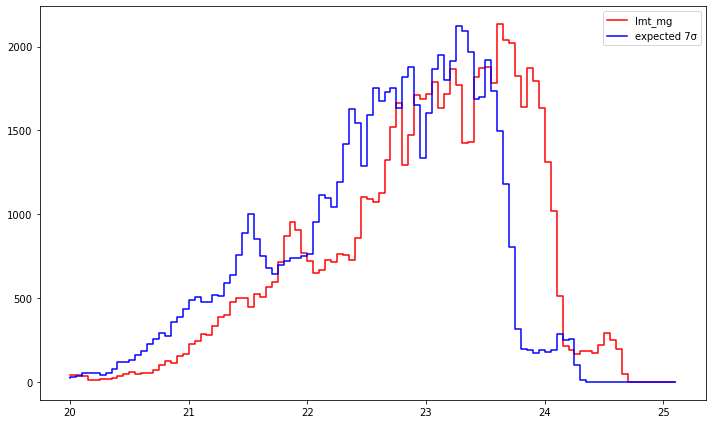

In [17]:
fig = pyplot.figure( figsize=(10,6), tight_layout=True )
ax = fig.add_subplot( 1, 1, 1 )
bins = numpy.arange( 20, 25.1, 0.05 )
lmtmghist, lmtmgbins = numpy.histogram( tmpinfo['lmt_mg'], bins=bins )
lmtmghist = numpy.append( lmtmghist, [0] )
exphist, expbins = numpy.histogram( tmpinfo['calclim'], bins=bins )
exphist = numpy.append( exphist, [0] )
ax.step( lmtmgbins, lmtmghist, color='red', label='lmt_mg' )
ax.step( expbins, exphist, color='blue', label=f'expected {DEFAULT_SIGLIM}σ' )
ax.legend()
fig.show()

In [21]:
# Look for objects (i.e. sources) with rb>0.9
fieldname = 'DECaPS-West'
# fieldname = None
filter='g'
q = ( f"SELECT e.mjd,o.mag,s.seeing,s.skysig,s.magzp AS subzp,s.lmt_mg,e.filter,(e.header->>'EXPTIME')::float AS exptime "
      f"FROM objects o "
      f"INNER JOIN objectrbs r ON r.object_id=o.id "
      f"INNER JOIN subtractions s ON o.subtraction_id=s.id "
      f"INNER JOIN exposures e ON s.exposure_id=e.id "
      f"WHERE {props} AND e.filter='{filter}' AND r.rbtype_id=1 AND r.rb>0.9" )
if fieldname is not None:
    q += f" AND {radec[fieldname]}"
print(q)
db.rollback()
cursor = db.cursor()
cursor.execute( q )
objinfo = pandas.DataFrame( cursor.fetchall() )


SELECT e.mjd,o.mag,s.seeing,s.skysig,s.magzp AS subzp,s.lmt_mg,e.filter,(e.header->>'EXPTIME')::float AS exptime FROM objects o INNER JOIN objectrbs r ON r.object_id=o.id INNER JOIN subtractions s ON o.subtraction_id=s.id INNER JOIN exposures e ON s.exposure_id=e.id WHERE e.proposalid IN ('2021A-0113','2021B-0149') AND e.filter='g' AND r.rbtype_id=1 AND r.rb>0.9 AND e.ra>115.3 AND e.ra<117.3 AND e.dec>-27.3 AND e.dec<-25.3


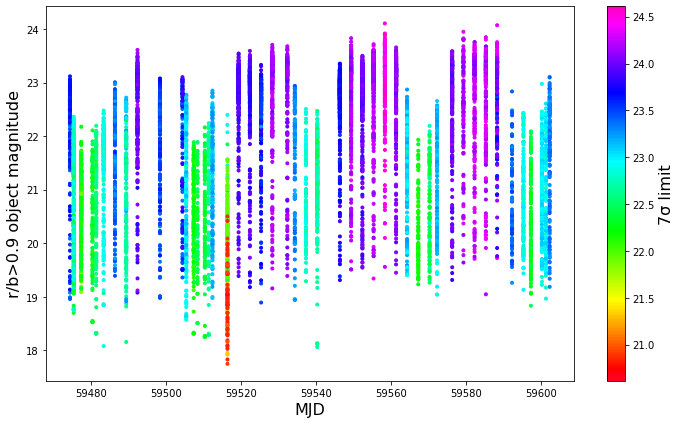

In [22]:
fig = pyplot.figure( figsize=(10,6), tight_layout=True )
ax = fig.add_subplot( 1, 1, 1 )
x = 'mjd'
xtitle = 'MJD'
y = 'mag'
ytitle = 'r/b>0.9 object magnitude'
c = 'lmt_mg'
ctitle = f'{DEFAULT_SIGLIM}σ limit'
sc = ax.scatter( objinfo[x], objinfo[y], c=objinfo[c], cmap='gist_rainbow', marker='.' )
ax.set_xlabel( xtitle, fontsize=16 )
ax.set_ylabel( ytitle, fontsize=16 )
cb = fig.colorbar(sc)
cb.set_label( ctitle, fontsize=16 )
fig.show()

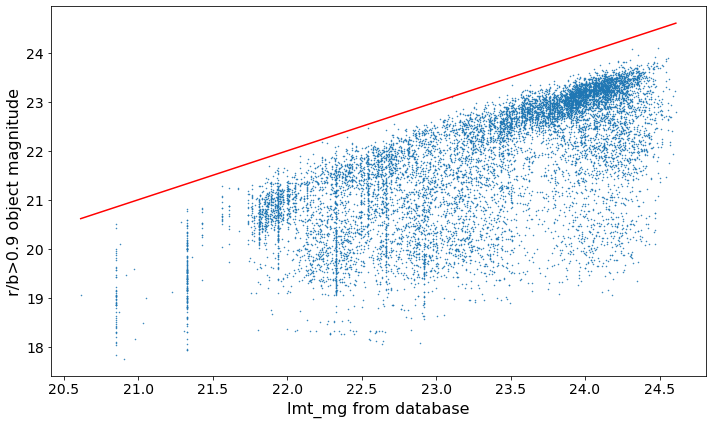

In [23]:
fig = pyplot.figure( figsize=(10,6), tight_layout=True )
ax = fig.add_subplot( 1, 1, 1 )
ax.tick_params( 'both', labelsize=14 )
ax.set_xlabel( 'lmt_mg from database', fontsize=16 ) # f'{DEFAULT_SIGLIM}σ limit', fontsize=16 )
ax.set_ylabel( f'r/b>0.9 object magnitude', fontsize=16 )
sc = ax.scatter( objinfo['lmt_mg'], objinfo['mag'], marker='.', s=1 )
minmax = [ min(objinfo['lmt_mg']), max(objinfo['lmt_mg']) ]
ax.plot( minmax, minmax, color='red' )

fig.show()
fig.savefig( 'it.png' )